In [1]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pandas as pd
import cv2

from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping

In [2]:
# load data
all_data= np.load(file="alldata_3D.npy")
all_lables=pd.read_csv('label.csv')
test_images=np.load(file='testdata_3D.npy')
test_lables=pd.read_csv('test_label.csv')

# create label binary array 
labels=[]
test_labels=[]
for i in range(3000):
    data = all_lables['label'][i]
    if data == 'no_tumor':
        #label.append(data)
        labels.append(0)
    else:
        #label.append('meningioma_tumor')
        labels.append(1)
        
for i in range(200):
    data = test_lables['label'][i]
    if data == 'no_tumor':
        #label.append(data)
        test_labels.append(0)
    else:
        #label.append('meningioma_tumor')
        test_labels.append(1)
        
labels = np.array(labels)
test_labels =np.array(test_labels)

In [3]:
# Normalize the pixel value into a floating-point number between 0 and 1.
all_data = np.array(all_data, dtype="float") / 255.0 
test_images= np.array(test_images, dtype="float") / 255.0

# Data Augmentation, Perform random horizontal flipping
aug = ImageDataGenerator(horizontal_flip=True)

# Direct adjustment of hyperparameter
INIT_LR = 0.005
EPOCHS = 30
BS = 64

# Divided into training set and verification set according to 8: 2
train_images,val_images,train_labels,val_labels=train_test_split(all_data,labels,test_size=0.2,random_state=0)

In [4]:
# LRN Local Response Normalization
class LRN(keras.layers.Layer):
    def __init__(self):
        super(LRN, self).__init__()
        self.depth_radius=2
        self.bias=1
        self.alpha=1e-4
        self.beta=0.75
    def call(self,x):
        return tf.nn.lrn(x,depth_radius=self.depth_radius,
                         bias=self.bias,alpha=self.alpha,
                         beta=self.beta)

In [5]:
#conv1+pool1+lrn1-->conv2+pool2+lrn2-->conv3-->conv4-->conv5+pool5-->fc1-->fc2-->fc3 Alexnet Model
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(filters=96, kernel_size=(11,11),strides=4,activation='relu',padding='same',input_shape=(224,224,3)))
model.add(keras.layers.MaxPool2D(pool_size=(3,3),strides=2))
model.add(LRN())
model.add(keras.layers.Conv2D(filters=256,kernel_size=(5,5),strides=1,activation='relu',padding='same'))
model.add(keras.layers.MaxPool2D(pool_size=(3,3),strides=2))
model.add(LRN())
model.add(keras.layers.Conv2D(filters=384,kernel_size=(3,3),strides=1,activation='relu',padding='same'))
model.add(keras.layers.Conv2D(filters=384,kernel_size=(3,3),strides=1,activation='relu',padding='same'))
model.add(keras.layers.Conv2D(filters=256,kernel_size=(3,3),strides=1,activation='relu',padding='same'))
model.add(keras.layers.MaxPool2D(pool_size=(3,3),strides=2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(4096,activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(4096,activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1,activation="sigmoid")) 
#Random gradient descent
#sgd = keras.optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
model.summary()
# sigmoid：from_logits=True Dense(1) 
# softmax：from_logits=Falese Dense(2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 56, 56, 96)        34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 96)        0         
_________________________________________________________________
lrn (LRN)                    (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 256)       614656    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 256)       0         
_________________________________________________________________
lrn_1 (LRN)                  (None, 13, 13, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 384)       8

In [6]:
#complie and fit the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INIT_LR), loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics=['accuracy'])
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1)
#history =model.fit(train_images, train_labels, batch_size=32, epochs=EPOCHS,validation_data=(val_images, val_labels),callbacks=[reduce_lr])
history =model.fit(aug.flow(train_images, train_labels, batch_size=BS), epochs=EPOCHS,validation_data=(val_images, val_labels))

Epoch 1/30


C:\Users\93650\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\backend.py:5016: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


38/38 [==============================] - 8s 86ms/step - loss: 0.7784 - accuracy: 0.8400 - val_loss: 0.4224 - val_accuracy: 0.8367
Epoch 2/30
38/38 [==============================] - 2s 56ms/step - loss: 0.3605 - accuracy: 0.8596 - val_loss: 0.4061 - val_accuracy: 0.8367
Epoch 3/30
38/38 [==============================] - 2s 58ms/step - loss: 0.2964 - accuracy: 0.8575 - val_loss: 0.3120 - val_accuracy: 0.8433
Epoch 4/30
38/38 [==============================] - 2s 64ms/step - loss: 0.2813 - accuracy: 0.8671 - val_loss: 0.2433 - val_accuracy: 0.9000
Epoch 5/30
38/38 [==============================] - 2s 57ms/step - loss: 0.2464 - accuracy: 0.8838 - val_loss: 0.2640 - val_accuracy: 0.8917
Epoch 6/30
38/38 [==============================] - 2s 57ms/step - loss: 0.2306 - accuracy: 0.8979 - val_loss: 0.2377 - val_accuracy: 0.8900
Epoch 7/30
38/38 [==============================] - 2s 55ms/step - loss: 0.2178 - accuracy: 0.9050 - val_loss: 0.2867 - val_accuracy: 0.8900
Epoch 8/30
38/38 [======

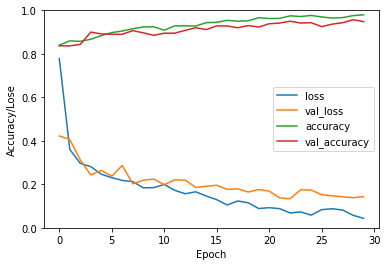

7/7 [==============================] - 0s 37ms/step - loss: 0.0871 - accuracy: 0.9650
0.9649999737739563 0.08712686598300934


In [7]:
#plot the curse and result
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy/Lose')
plt.ylim([0, 1])
plt.legend(loc='center right')
plt.show()

test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=1)
print(test_acc, test_loss)